In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../../../devel/lib/python2.7/dist-packages')
sys.path.insert(0, '../../../src/merganser/packages/merganser_line_detector/include')
sys.path.insert(0, '../../../src/merganser/packages/merganser_bezier/include')

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

import json

import duckietown_utils as dtu
from merganser_line_detector.line_detector import LineDetectorHSV
from merganser_line_detector.utils import detections_to_image, skeletons_to_image

In [4]:
from merganser_bezier.bezier import Bezier, compute_curve

In [5]:
config_filename = '../../../src/merganser/packages/merganser_line_detector/config/merganser_line_detector_node/default.yaml'

In [6]:
with open(config_filename, 'r') as f:
    config = dtu.yaml_load(f.read())
configuration = config['detector'][1]['configuration']

In [7]:
detector = LineDetectorHSV(configuration)

In [8]:
def process_image(image, config):
    img_size = config['img_size']
    top_cutoff = config['top_cutoff']
    img = cv2.resize(image, (img_size[1], img_size[0]))
    return img[top_cutoff:]

In [9]:
filename = 'skeletons_log_11-25_2.json'
with open(filename, 'rb') as f:
    skeletons_frames = json.load(f)

In [10]:
choice = np.linspace(.2, .8, 4).reshape(-1, 1)
choice = np.hstack((choice, choice))
choice

array([[ 0.2,  0.2],
       [ 0.4,  0.4],
       [ 0.6,  0.6],
       [ 0.8,  0.8]])

In [11]:
cloud = np.array(skeletons_frames[0]['white'][0]).T

In [12]:
len(cloud)

98

In [13]:
bezier = Bezier(4, 100, choice=cloud)

In [15]:
%timeit bezier.nll(cloud)

1000 loops, best of 3: 205 µs per loop


In [16]:
%timeit bezier.fit(cloud, steps=1, eps=0)

100 loops, best of 3: 2.5 ms per loop


In [23]:
bezier.fit(cloud, steps=10, eps=0, lr=.1)

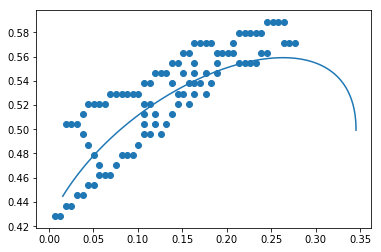

In [24]:
plt.plot(*bezier().T)
plt.scatter(*cloud.T, alpha=.5)

In [25]:
%%timeit
bezier = Bezier(4, 20, choice=cloud)
bezier.fit(cloud, steps=100, eps=0.001, lr=.01)

10 loops, best of 3: 21.6 ms per loop


In [35]:
bezier = Bezier(4, 20, choice=cloud)
bezier.fit(cloud, steps=100, eps=0.001, lr=.01)

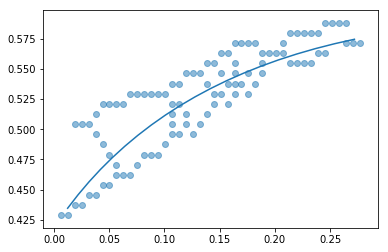

In [36]:
plt.plot(*bezier().T)
plt.scatter(*cloud.T, alpha=.5)

In [37]:
%%timeit
bezier = Bezier(4, 20, choice=cloud)
bezier.closed_form(cloud)

100 loops, best of 3: 2.74 ms per loop


In [38]:
bezier = Bezier(4, 20, choice=cloud)
bezier.closed_form(cloud)

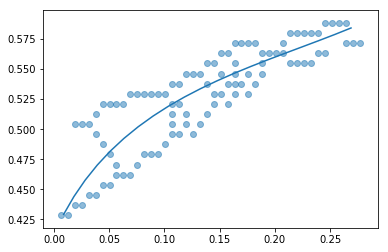

In [39]:
plt.plot(*bezier().T)
plt.scatter(*cloud.T, alpha=.5)

In [53]:
bezier = Bezier(4, 20, choice=cloud)

bezier.closed_form(cloud)
bezier.closed_form(cloud)
bezier.closed_form(cloud)
bezier.closed_form(cloud)

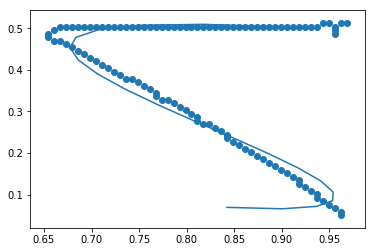

In [54]:
plt.plot(*bezier().T)
plt.scatter(*cloud.T)

In [ ]:
%%timeit
bezier = Bezier(4, 100, choice=cloud)
bezier.closed_form(cloud)

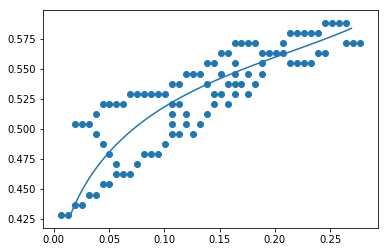

In [39]:
params = bezier.closed_form(cloud)
bezier.controls = params
plt.plot(*bezier().T)
plt.scatter(*cloud.T)

In [31]:
params

array([[ 0.00419374,  0.42452775],
       [ 0.0656851 ,  0.52608448],
       [ 0.16880441,  0.5469147 ],
       [ 0.26626558,  0.58344595]])

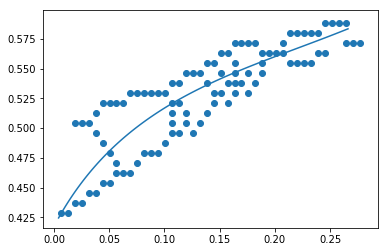

In [32]:
plt.plot(*compute_curve(params).T)
plt.scatter(*cloud.T)

In [40]:
bezier.nll(cloud)

0.031189449902748516

In [30]:
class BezierWrapper:
    
    def __init__(self):
        
        self.beziers = dict(red=[], yellow=[], white=[])
        
        self.curve_precision = 20
        self.reg = .01
        self.eps = .001
        self.lr = .01
        self.fitting_steps = 100
        self.loss_threshold = .001
        
    def process_cloud(self, cloud, color):
        
        choice = np.linspace(.2, .8, 4).reshape(-1, 1)
        choice = np.hstack((choice, choice))
        
        beziers = self.beziers[color]
        
        losses = np.array([b.loss(cloud) for b in beziers])
        argmin = losses.argmin() if len(losses) > 0 else -1

        if argmin > -1 and losses[argmin] < self.loss_threshold:
            bezier = beziers[argmin].copy()
        else:
            bezier = Bezier(4, self.curve_precision, choice=cloud, reg=self.reg)
        
#         bezier.extrapolate(-.05, 1.05)
            
        bezier.fit(
            cloud=cloud,
            steps=self.fitting_steps,
            eps=self.eps,
            lr=self.lr,
        )
        
        return bezier, color
    
    def process_clouds(self, skeletons):
        pass

In [31]:
bw = BezierWrapper()

In [48]:
def plot_skeletons(skeletons, save=''):
    
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_facecolor('black')
    
    plt.xlim(0, 1)
    plt.ylim(0, .8)
    
    for color in ['white', 'yellow', 'red']:
        beziers = []
        for skeleton in skeletons[color]:
            
            cloud = np.array(skeleton).T

            if len(cloud) < 20:
                continue

            b, c = bw.process_cloud(cloud, color)
            
            beziers.append(b)
            
#             plt.plot(*b().T, lw=5, color='black')
            plt.plot(*b().T, lw=5, color=color)
            plt.scatter(*cloud.T, alpha=.5, c=color)
        
        bw.beziers[color] = beziers
    
    if save:
        plt.savefig(save, bbox_inches='tight', dpi=200)
        plt.close()
        
    else:
        plt.show()

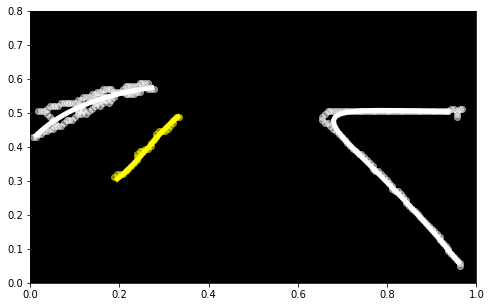

In [49]:
plot_skeletons(skeletons_frames[0]) #, 'output/skeletons_1.png')

In [46]:
from tqdm import tqdm

In [50]:
for i, skeletons in enumerate(tqdm(skeletons_frames[150:], ascii=True, ncols=100)):
    plot_skeletons(skeletons, 'output/skeletons3/skeletons_%03d.png' % (i, ))

100%|#############################################################| 833/833 [17:37<00:00,  1.27s/it]
